# Simulate random numbers distribution with Markov Chain Monte Carlo Metropolis-Hastings algorithm.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Mean of Results: 0.010959817394561611
Std. Dev. of Results: 1.35044548921066
min(results): -6.250154977129033
max(results) 5.862070548595892


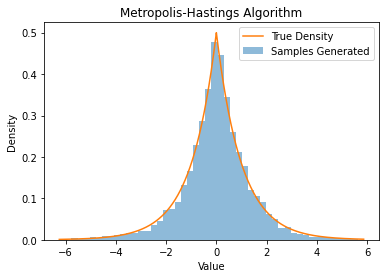

In [40]:
# ===== part 1 a: mcmc algorithm random walk =====

# creating pdf of x
def f(x):
    return 0.5*np.exp(-np.abs(x))

# metropolis-hastings algorithm
def metropolis_hastings(x0, N, s):
    samples = np.zeros(N) ## pre-allocating memory in array for sample size N
    current_x = x0 ## starting with x0 as xi-1

    for i in range (1,N):
        # step 1: simulating random x that is X*~(Xi-1, s)
        simulated_x = np.random.normal(loc=current_x, scale=s)
        
        # step 2: computing r ratio of f(x*)/f(xi-1)
        r_ratio = f(simulated_x)/f(current_x)
        
        # step 3: generating random number u that is U~(0,1)
        u = np.random.uniform(0,1)
        
        # step 4: if ratio is larger than u, keep. if not, go next
        if np.log(u) < np.log(r_ratio):
            current_x = simulated_x
            
        samples[i] = current_x
        
    return samples

# setting up variable and parameters 
x0 = 0 ## first explanatory variable
N = 10000 ## sample size
s = 1 ## sd/scale

# calling algorithm samples
results = metropolis_hastings(x0, N, s)

# array of evenly spaced values conditioned on max(results) and min(results)
x_range = np.linspace(min(results), max(results), 10000)

# visualize the results and given f(x)
plt.hist(results, bins=50, density=True, alpha=0.5, label='Samples Generated') ## hist. of "results"
plt.plot(x_range, f(x_range), label='True Density') ## plot of given pdf
plt.title('Metropolis-Hastings Algorithm')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()

# mean and sd of results
results_mean = np.mean(results)
print("Mean of Results:", results_mean)
results_std = np.std(results)
print("Std. Dev. of Results:", results_std)
results_min = min(results)
print("min(results):", results_min)
results_max = max(results)
print("max(results)", results_max)

Text(0, 0.5, 'R Hat')

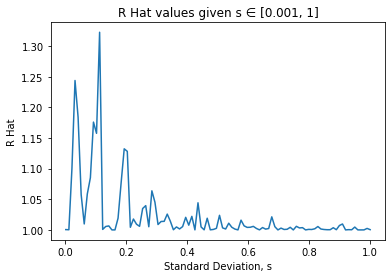

In [42]:
# ===== part 1 b: R-Hat Gelman-Rubin diagnostics =====

# step 1.1 sample mean of chain
def Mj(chain):
    return np.sum(chain) / len(chain)

# step 1.2  sample variance of chain
def Vj(chain):
    return np.sum((chain - Mj(chain))**2) / len(chain)

# step 1.3 within sample variance 
def W(chain):
    return np.sum(Vj(chain)) / J

# step 2.1 overall sample mean
def M(chain):
    return np.sum(Mj(chain)) / J

# step 2.2 between sample variance
def B(chain):
    return np.sum((Mj(chain) - M(chain))**2) / J

# step 3 apply within sample variance and between sample variance to calculate R hat
def R_Hat(chain):
    return np.sqrt((B(chain) + W(chain)) / W(chain))

# function that loops each chain to find R Hat value across iterations of s between 0.001 to 1
def rhat_list_for_s_values(N, s_values, J):
    rhat_values = []
    for s in s_range:
        # creating chains based on 1a
        chains = metropolis_hastings(x0, N, s)

        # run every chain value through R Hat formula
        rhat = R_Hat(chains)

        # append rhat 
        rhat_values.append(rhat)
        
    return rhat_values

# setting up variable and parameters 
N = 2000
J = 4 
s_range = np.linspace(0.001,1,100) ## array of evenly spaced values conditioned on 0.001, 1

# calling R hat values
rhat_values = rhat_list_for_s_values(N, s_values, J)

# visualize given R hat results
plt.plot(s_range, rhat_values)
plt.title('R Hat values given s ∈ [0.001, 1]')
plt.xlabel('Standard Deviation, s')
plt.ylabel('R Hat')

In [2]:
import pandas as pd
import sqlite3

# creating connection for qn 2
conn = sqlite3.connect('py_coursework.db')

In [10]:
# ===== reading 1997 to 2007, planedata, airport and carrier csv =====

# df for all years csv
master = pd.DataFrame()

# reading all years csv into df (1998:2007)
for year in range(2003, 2005):
    files = f'{year}.csv' ## creating objects as '1998.csv' to '2007.csv'
    years = pd.read_csv(files) ## reads all csv
    master = master.append(years) ## appends into single df

# reading non-year csv
planes = pd.read_csv('plane-data.csv')
airports = pd.read_csv('airports.csv')
carriers = pd.read_csv('carriers.csv')

# descriptive statistics and checking data
print(master.head())
print(master['ArrDelay'].describe())
print(master['DepDelay'].describe())
print((master['DepDelay'] + master['ArrDelay']).describe())
print(master.info())

   Year  Month  DayofMonth  DayOfWeek  DepTime  CRSDepTime  ArrTime  \
0  2003      1          29          3   1651.0        1655   1912.0   
1  2003      1          30          4   1654.0        1655   1910.0   
2  2003      1          31          5   1724.0        1655   1936.0   
3  2003      1           1          3   1033.0        1035   1625.0   
4  2003      1           2          4   1053.0        1035   1726.0   

   CRSArrTime UniqueCarrier  FlightNum  ... TaxiIn  TaxiOut  Cancelled  \
0        1913            UA       1017  ...      5       17          0   
1        1913            UA       1017  ...      2       26          0   
2        1913            UA       1017  ...      5       17          0   
3        1634            UA       1018  ...      6       11          0   
4        1634            UA       1018  ...     13       46          0   

   CancellationCode  Diverted  CarrierDelay WeatherDelay NASDelay  \
0               NaN         0           NaN          NaN   

In [9]:
# ===== reading all data into SQL DB =====
master.to_sql('master', conn, if_exists='replace')
planes.to_sql('planes', conn, if_exists='replace')
airports.to_sql('airports', conn, if_exists='replace')
carriers.to_sql('carriers', conn, if_exists='replace')

In [4]:
# ===== part 2 a: querying best times to minimise delay each year =====
# update '2400' to '0000' in the db
conn.execute("UPDATE master SET CRSDepTime = 0 WHERE CRSDepTime = 2400")
conn.commit()

# querying out year, deptime(as time period) and depdelay+arrdelay
best_time_query = """
  SELECT
    Year,
    CASE
      WHEN CRSDepTime BETWEEN 000 AND 559 THEN '0000-0559' 
      WHEN CRSDepTime BETWEEN 0600 AND 1159 THEN '0600-1159'
      WHEN CRSDepTime BETWEEN 1200 AND 1759 THEN '1200-1759'
      WHEN CRSDepTime BETWEEN 1800 AND 2359 THEN '1800-2359'
    END AS TimePeriod, 
    AVG(DepDelay + ArrDelay) AS Avg_Delay
  FROM
    master
  WHERE
    CRSDepTime <> 'NA' --removes cancelled flights
  GROUP BY
    Year, TimePeriod
"""

# executing query
best_time = conn.execute(best_time_query).fetchall()
# converting from str to df 
best_time_df = pd.DataFrame(best_time,columns=['Year', 'TimePeriod', 'Avg_Delay'])

print(best_time_df)

   Year TimePeriod  Avg_Delay
0  2003  0000-0559  -0.112575
1  2003  0600-1159   2.362362
2  2003  1200-1759  11.775062
3  2003  1800-2359  15.613596
4  2004  0000-0559   1.486669
5  2004  0600-1159   5.174693
6  2004  1200-1759  18.091216
7  2004  1800-2359  25.129560


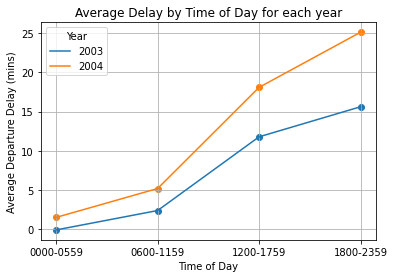

In [6]:
# ===== part 2 a: plot best times each year =====
time_order = ['0000-0559', '0600-1159', '1200-1759', '1800-2359']

# create a line plot
for year in best_time_df['Year'].unique():
    yearly_data = best_time_df[best_time_df['Year'] == year]
    plt.plot(yearly_data['TimePeriod'], yearly_data['Avg_Delay'], label=year)
    plt.scatter(yearly_data['TimePeriod'], yearly_data['Avg_Delay']) ## creates points on line

# aesthetics and labels
plt.title('Average Delay by Time of Day for each year')
plt.xlabel('Time of Day')
plt.ylabel('Average Departure Delay (mins)')
plt.xticks(time_order)
plt.legend(title='Year')
plt.grid(True)

In [7]:
# ===== part 2 a: querying best days of week to minimise delay each year =====
# querying out year, dayofweek and depdelay+arrdelay
best_day_query = """
  SELECT
    Year,
    DayOfWeek,
    AVG(DepDelay + ArrDelay) AS Avg_Delay
  FROM
    master
  WHERE
    CRSDepTime <> 'NA' --removes cancelled flights
  GROUP BY
    Year, DayofWeek
  ORDER BY
    DayOfWeek ASC
"""

# executing query
best_day = conn.execute(best_day_query).fetchall()
best_day_df = pd.DataFrame(best_day, columns=['Year', 'DayOfWeek', 'Avg_Delay'])

print(best_day_df)
best_day_df.info()

    Year  DayOfWeek  Avg_Delay
0   2003          1   9.474778
1   2004          1  16.755003
2   2003          2   6.548184
3   2004          2  12.077799
4   2003          3   7.651816
5   2004          3  14.234076
6   2003          4  11.061815
7   2004          4  16.699787
8   2003          5  12.033242
9   2004          5  16.923894
10  2003          6   4.342632
11  2004          6   8.430273
12  2003          7  10.034318
13  2004          7  14.573294
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Year       14 non-null     int64  
 1   DayOfWeek  14 non-null     int64  
 2   Avg_Delay  14 non-null     float64
dtypes: float64(1), int64(2)
memory usage: 464.0 bytes


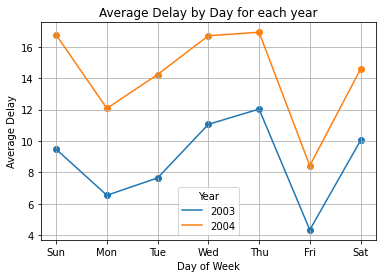

In [9]:
# ===== part 2 a: plot best days each year =====
# create a line plot
for year in best_day_df['Year'].unique():
    yearly_data = best_day_df[best_day_df['Year'] == year]
    plt.plot(yearly_data['DayOfWeek'], yearly_data['Avg_Delay'], label=year)
    plt.scatter(yearly_data['DayOfWeek'], yearly_data['Avg_Delay']) ## creates points on line

# aesthetics and labels
plt.title('Average Delay by Day for each year')
plt.xlabel('Day of Week')
plt.xticks(ticks=range(1, 8), labels=['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']) ## change x ticks to name of day from no.
plt.ylabel('Average Delay')
plt.legend(title='Year')
plt.grid(True)


In [13]:
# ===== part 2 b: querying plane age and avg delay =====
# change all irrelevant string data to NULL. note '0000' is a string, not '0'
conn.execute("UPDATE planes SET year = NULL WHERE year = '0000' OR year IS NULL OR year LIKE 'None%' OR year = ''")
conn.commit()


plane_age_query = """
  SELECT
    master.Year,
    master.TailNum,
    (master.Year - CAST(planes.year AS INTEGER)) AS Age,
    AVG(DepDelay + ArrDelay) AS Avg_Delay
  FROM
    master
  INNER JOIN
    planes
    ON master.TailNum = planes.tailnum
  WHERE 
    planes.year IS NOT NULL AND
    (master.Year - CAST(planes.year AS INTEGER)) > 0
  GROUP BY
    master.Year, 
    master.TailNum
"""

# executing query
age_and_delay = conn.execute(plane_age_query).fetchall()
age_and_delay_df = pd.DataFrame(age_and_delay, columns = ['Year', 'TailNum', 'Age', 'Avg_Delay'])

print(age_and_delay_df)

      Year TailNum  Age  Avg_Delay
0     2003  N102UW    5   8.510851
1     2003  N10323   17   8.567057
2     2003  N104UA    5  17.046154
3     2003  N104UW    4   4.396539
4     2003  N10575    1  10.991182
...    ...     ...  ...        ...
5585  2004  N997DL   12  18.482132
5586  2004  N998AT    2  15.163215
5587  2004  N998DL   12  20.635991
5588  2004  N999CA    6  12.539428
5589  2004  N999DN   12  20.895897

[5590 rows x 4 columns]


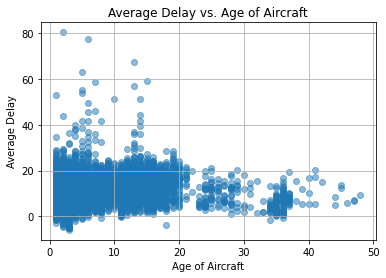

In [14]:
# ===== part 2 a: plotting scatter of age against delay =====
plt.scatter(age_and_delay_df['Age'], age_and_delay_df['Avg_Delay'], alpha=0.5)
plt.xlabel('Age of Aircraft')
plt.ylabel('Average Delay')
plt.title('Average Delay vs. Age of Aircraft')
plt.grid(True)
plt.show()